# Q1 - Adaboost
## Alireza Habibzadeh `99109393`

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

train_data = pd.read_csv('Syndata-train.csv')
test_data = pd.read_csv('Syndata-test.csv')

# Separating features and label
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

In [3]:
def find_best_stump(X, y, weights):
    n_samples, n_features = X.shape
    best_stump = {'feature': None, 'threshold': None, 'polarity': None}
    best_error = float('inf')

    for feature in range(n_features):
        feature_values = X.iloc[:, feature]
        thresholds = np.unique(feature_values)

        for threshold in thresholds:
            for polarity in [1, -1]:
                # Predict
                predictions = np.ones(n_samples)
                if polarity == 1:
                    predictions[feature_values < threshold] = -1
                else:
                    predictions[feature_values >= threshold] = -1

                weighted_error = np.dot(weights, predictions != y)

                if weighted_error < best_error:
                    best_error = weighted_error
                    best_stump['feature'] = feature
                    best_stump['threshold'] = threshold
                    best_stump['polarity'] = polarity
    return best_stump, best_error

In [4]:
def stump_predict(X, stump):
    feature, threshold, polarity = stump['feature'], stump['threshold'], stump['polarity']
    predictions = np.ones(len(X))

    if polarity == 1:
        predictions[X.iloc[:, feature] < threshold] = -1
    else:
        predictions[X.iloc[:, feature] >= threshold] = -1
    return predictions


def Adaboost_predict(X, stumps, weights):
    stump_preds = np.array([stump_predict(X, stump) for stump in stumps]).T
    return np.sign(stump_preds.dot(weights))


def Adaboost(X_train, y_train, X_test, num_iter, verbose=False):
    n_train = X_train.shape[0]
    weights = np.full(n_train, 1 / n_train)

    stumps = []
    stump_weights = []
    weighted_errors = []
    train_errors = []
    test_errors = []

    for _ in tqdm(range(num_iter)):
        best_stump, error = find_best_stump(X_train, y_train, weights)
        stump_pred = stump_predict(X_train, best_stump)

        stump_weight = np.log((1 - error) / error) / 2

        # Update the weights
        weights *= np.exp(-stump_weight * y_train * stump_pred)
        weights /= np.sum(weights)  # Normalize

        # Store the stump
        stumps.append(best_stump)
        stump_weights.append(stump_weight)
        
        if verbose:
            weighted_errors.append(error)
            train_errors.append(np.mean(Adaboost_predict(X_train, stumps, stump_weights) != y_train))
            test_errors.append(np.mean(Adaboost_predict(X_test, stumps, stump_weights) != y_test))
            
    y_pred = Adaboost_predict(X_test, stumps, stump_weights)
    if verbose:
        return y_pred, (weighted_errors, train_errors, test_errors)
    
    test_error = np.mean(y_pred != y_test)
    train_error = np.mean(Adaboost_predict(X_train, stumps, stump_weights) != y_train)
    return y_pred, (train_error, test_error)

## 1

In [5]:
T = 20
y_pred, (weighted_errors, train_errors, test_errors) = Adaboost(X_train, y_train, X_test, T, verbose=True)

print(f'Error of Adaboost with {T} iterations: Test error = {test_errors[-1]:.2%} | Train error = {train_errors[-1]:.2%}')

100%|██████████| 20/20 [00:03<00:00,  5.96it/s]

Error of Adaboost with 20 iterations: Test error = 7.00% | Train error = 6.88%


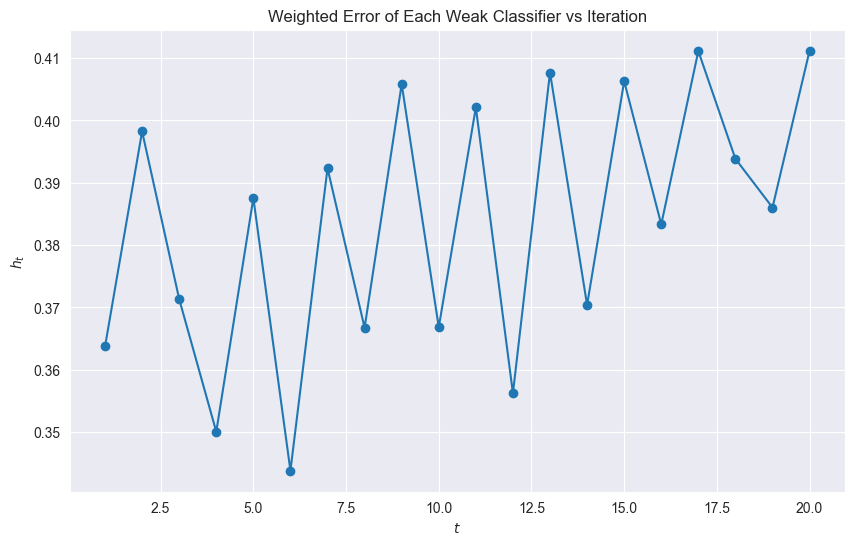

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, T + 1), weighted_errors, marker='o', linestyle='-')
plt.title('Weighted Error of Each Weak Classifier vs Iteration')
plt.xlabel(r'$t$')
plt.ylabel(r'$h_t$')
plt.grid(True)
plt.show()

آدابوست هر بار داده‌هایی را که اشتباه دسته‌بندی شده‌اند بولد می‌کند و تا آن‌ها را اصلاح کند. برای همین خطا نوسان می‌کند. بیشترین خطا فکر کنم در آخرین مرحله رخ می‌دهد که در زیر پیدا شده. ضمنا در کل به طور متوسط انگار خطای وزن دار در حال افزایش است.

In [7]:
print(f'Maximum error: {max(weighted_errors):.2%}, On iteration: {np.argmax(weighted_errors) + 1}')

Maximum error: 41.12%, On iteration: 20


## 2

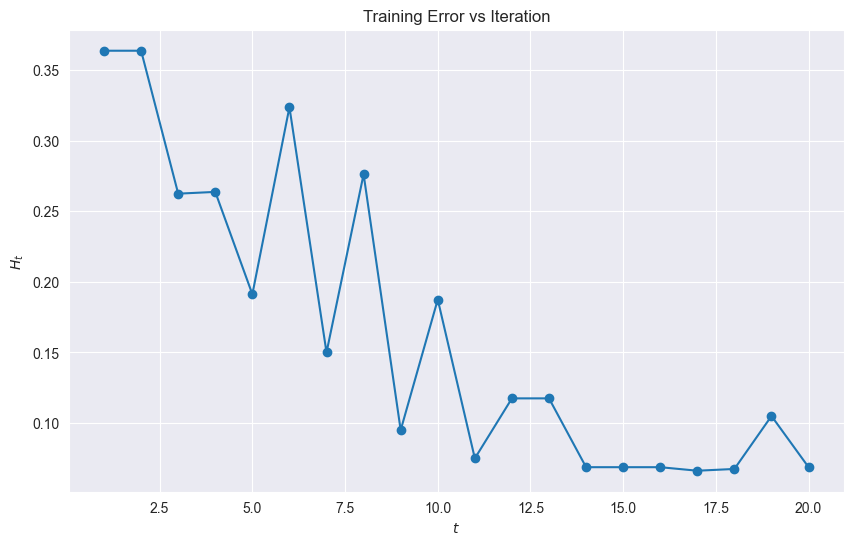

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, T + 1), train_errors, marker='o', linestyle='-')
plt.title('Training Error vs Iteration')
plt.xlabel(r'$t$')
plt.ylabel(r'$H_t$')
plt.grid(True)
plt.show()


خطای مدل کلی روی داده‌های یادگیری در حال کاهش است که این خوب است و یعنی آدابوست به درستی کار می‌کند و به داده‌های یادگیری فیت می‌شود. البته هنوز نمیدانیم اورفیت است یا فیت خوب.

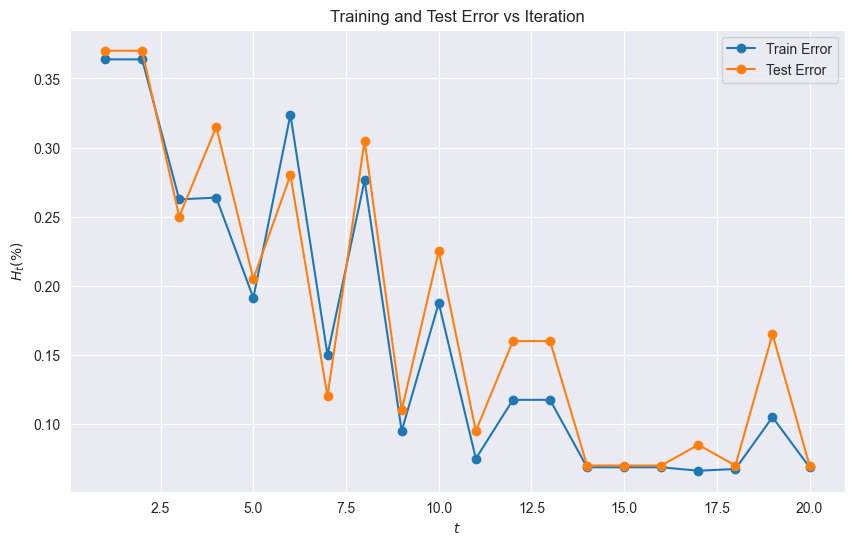

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, T + 1), train_errors, marker='o', linestyle='-', label='Train Error')
plt.plot(range(1, T + 1), test_errors, marker='o', linestyle='-', label='Test Error')
plt.title('Training and Test Error vs Iteration')
plt.xlabel(r'$t$')
plt.ylabel(r'$H_t (\%)$')
plt.grid(True)
plt.legend()
plt.show()


نمودار بالا نشان می‌دهد فیت خوب و کم شدن خطای یادگیری اورفیت نبوده. چنانچه خطای تست هم که طبق باندهافدینگ می‌دانیم نباید چندان با خطای یادگیری متفاوت باشد تقریبا نزدیک خطای یادگیری در حال کاهش است. نمودار به خوبی نشان می‌دهد که 
$E_{out}$
و
$E_{in}$
زیاد از هم دور نمی‌شوند.

In [10]:
Ts = [20, 50, 100, 200, 500, 1000, 2000, 4000]
T_test_errors = []
T_train_errors = []

for t in Ts:
    _, (train_error, test_error) = Adaboost(X_train, y_train, X_test, t)
    T_test_errors.append(test_error)
    T_train_errors.append(train_error)

100%|██████████| 4000/4000 [09:18<00:00,  7.16it/s]


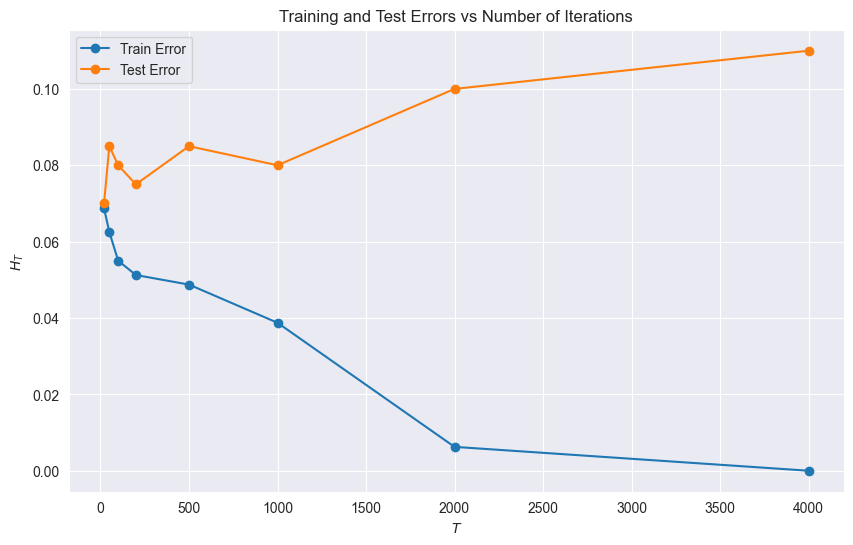

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(Ts, T_train_errors, marker='o', linestyle='-', label='Train Error')
plt.plot(Ts, T_test_errors, marker='o', linestyle='-', label='Test Error')
plt.title('Training and Test Errors vs Number of Iterations')
plt.xlabel(r'$T$')
plt.ylabel(r'$H_T$')
plt.grid(True)
plt.legend()
plt.show()


نمودار نشان می‌دهد از ۲۰ به بعد و شاید هم در ۲۰۰ به بعد دیگر اورفیت است و صرفا خطای یادگیری را کم می‌کنیم و خطای تست زیاد می‌شود.

خطای یادگیری پیوسته کاهش می‌یابد چرا که هر بار آدابوست پیچیده‌تری را امتحان می‌کنیم. اما روند خطای تست تا ۲۰۰ نزولی است و پس از آن صعودی است. جز مورد خاص ۲۰ که از همه کمتر شده.

از آنجایی که خطای تست و یادگیری در ۲۰ هم زیاد تفاوتی ندارند به نظر من همان ۲۰ یا نزدیک به آن جایی است که یک مدل بسیار کلی و 
general
ارائه داده‌ایم که خطای تست خوبی هم دارد.